# Global imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Qiskit
from qiskit import BasicAer
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit_machine_learning.datasets import ad_hoc_data

# Scikit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn import metrics
from sklearn.svm import SVC
from collections import Counter

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores
# Custom visualization tools
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions

from qksvm.QuantumFeatureMap import QuantumFeatureMap
from qksvm.QKSVC import QKSVC

seed = 12345

# Qiskit Ad Hoc dataset

In [2]:
np.random.seed(seed=77)
algorithm_globals.random_seed = seed

# generate the dataset
adhoc_dimension = 2
X, y, _, _, adhoc_total = ad_hoc_data(
    training_size=1000,
    test_size=2,
    n=adhoc_dimension,
    gap=0.2,
    plot_data=False,
    one_hot=False,
    include_sample_total=True
)
y = 2*y-1

print(f"Dataset statistics: {Counter(y)}")

Dataset statistics: Counter({-1: 1000, 1: 1000})


In [3]:
train_size = 300
test_size = 100
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    stratify=y, random_state=42,
)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({-1: 150, 1: 150})
Testing target statistics: Counter({1: 50, -1: 50})


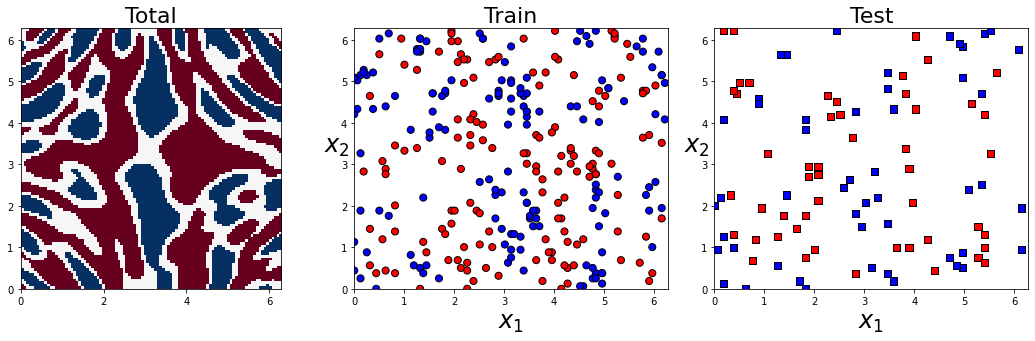

In [4]:
# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# visualize the dataset
xmin = 0; xmax = 2*np.pi
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=22)
ax1.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap=plt.cm.RdBu_r,
    extent=axes,
)

ax2.set_title("Train", fontsize=22)
plot_dataset(X_train, y_train, ax2, axes, marker='o', size=50, stepsize=1.0)
ax2.grid(False)

ax3.set_title("Test", fontsize=22)
plot_dataset(X_test, y_test, ax3, axes, marker='s', size=50, stepsize=1.0)
ax3.grid(False)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

## Visualize the classifier

In [5]:
def plot_results(clf, N=20):
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap=plt.cm.RdBu_r,
        extent=axes,
    )
    plot_predictions(clf, axs[1], axes, N=N)
    plot_dataset(X_test, y_test, axs[1], axes, stepsize=1.0)
    plot_decisions(clf, axs[2], axes, N=N)
    plot_dataset(X_test, y_test, axs[2], axes, stepsize=1.0)
    plt.tight_layout()
    plt.show()   

# RBF kernel

Best grid search parameters: {'C': 1, 'gamma': 10.0}
Best training score: 0.8366666666666667

Train set:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  0.99

Test set:
   Balanced accuracy:  0.88
                  F1:  0.88
             ROC_AUC:  0.95
                 MCC:  0.76


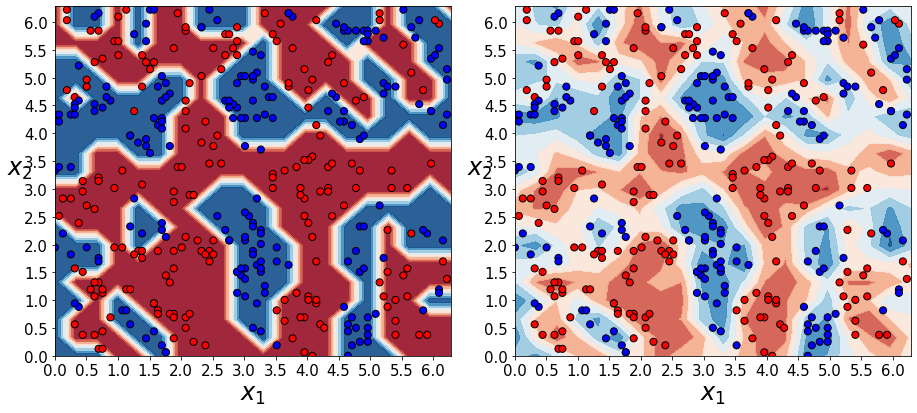

In [6]:
np.random.seed(seed)

param_grid = {
    "gamma": [0.001, 0.01, 0.1, 1.0, 5.0, 8.0, 9.0, 10.0, 11.0],
    "C": [1, 5, 10, 20, 50, 100, 1000],
}

gs = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
)
gs.fit(X_train, y_train)

print('Best grid search parameters:', gs.best_params_)
print('Best training score:', gs.best_score_)

scores_ = get_scores(gs.best_estimator_, X_train, y_train)
print_scores(scores_, title='Train set:')

scores_ = get_scores(gs.best_estimator_, X_test, y_test)
print_scores(scores_, title='Test set:')

# plot_results(clf.best_estimator_, N=40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(gs.best_estimator_, ax1, axes, N=20)
plot_dataset(X[::5,:], y[::5], ax1, axes)
plot_decisions(gs.best_estimator_, ax2, axes, N=20)
plot_dataset(X[::5], y[::5], ax2, axes)
plt.tight_layout()
plt.show()

## Model cross-validation

In [7]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

param_grid = {
    "gamma": [0.001, 0.01, 0.1, 1.0, 5.0, 8.0, 9.0, 10.0, 11.0],
    "C": [1, 5, 10, 20, 50, 100, 1000],
}

train_size = 300
test_size = 50
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        clf = GridSearchCV(
            estimator=SVC(kernel='rbf'),
            param_grid=param_grid,
            scoring='matthews_corrcoef',
            n_jobs=1,
            refit=True,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=_seed),
        )

        clf.fit(X[train,:], y[train])

        train_scores = get_scores(clf.best_estimator_, X[train,:], y[train])
        test_scores = get_scores(clf.best_estimator_, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_clf = clf.best_estimator_

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  0.98

Train set:
   Balanced accuracy:  1.00 +- 0.00
                  F1:  1.00 +- 0.00
             ROC_AUC:  1.00 +- 0.00
                 MCC:  1.00 +- 0.01

Test set:
   Balanced accuracy:  0.90 +- 0.04
                  F1:  0.90 +- 0.04
             ROC_AUC:  0.97 +- 0.02
                 MCC:  0.81 +- 0.08


# QSVM 

## H-RZ-CX 

     ┌───┐ ┌────────────┐       ┌───┐ ┌────────────┐       
q_0: ┤ H ├─┤ Rz(x[0]*α) ├───■───┤ H ├─┤ Rz(x[0]*α) ├───■───
     ├───┤ ├────────────┤ ┌─┴─┐ ├───┤ ├────────────┤ ┌─┴─┐ 
q_1: ┤ H ├─┤ Rz(x[1]*α) ├─┤ X ├─┤ H ├─┤ Rz(x[1]*α) ├─┤ X ├─
     └───┘ └────────────┘ └───┘ └───┘ └────────────┘ └───┘ 

Train scores:
   Balanced accuracy:  0.76
                  F1:  0.76
             ROC_AUC:  0.86
                 MCC:  0.52

Test scores:
   Balanced accuracy:  0.75
                  F1:  0.75
             ROC_AUC:  0.76
                 MCC:  0.50


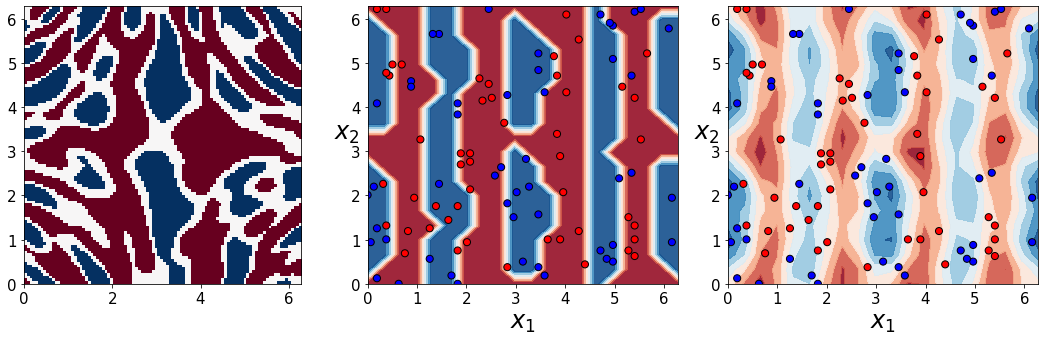

In [8]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=2,
    num_layers=2,
    gates=['h', 'RZ', 'cx',], entanglement='linear',
)
print(fm.draw(plot_barriers=False, fold=120))

backend = QuantumInstance(
    AerSimulator(method="statevector"),
    seed_simulator=seed, seed_transpiler=seed,
    backend_options = {'method': 'automatic', 
                       'max_parallel_threads': 0,
                       'max_parallel_experiments': 0,
                       'max_parallel_shots': 0},
)

qsvc = QKSVC(feature_map=fm, alpha=2.0, C=1, random_state=seed, backend=backend)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=20)

     ┌───┐ ┌────────────┐                 ┌───┐ ┌────────────┐                 
q_0: ┤ H ├─┤ Rz(x[0]*α) ├───■─────────────┤ H ├─┤ Rz(x[0]*α) ├───■─────────────
     ├───┤ ├────────────┤ ┌─┴─┐           ├───┤ ├────────────┤ ┌─┴─┐           
q_1: ┤ H ├─┤ Rz(x[1]*α) ├─┤ X ├──■────────┤ H ├─┤ Rz(x[1]*α) ├─┤ X ├──■────────
     ├───┤ ├────────────┤ └───┘┌─┴─┐      ├───┤ ├────────────┤ └───┘┌─┴─┐      
q_2: ┤ H ├─┤ Rz(x[0]*α) ├──────┤ X ├──■───┤ H ├─┤ Rz(x[0]*α) ├──────┤ X ├──■───
     ├───┤ ├────────────┤      └───┘┌─┴─┐ ├───┤ ├────────────┤      └───┘┌─┴─┐ 
q_3: ┤ H ├─┤ Rz(x[1]*α) ├───────────┤ X ├─┤ H ├─┤ Rz(x[1]*α) ├───────────┤ X ├─
     └───┘ └────────────┘           └───┘ └───┘ └────────────┘           └───┘ 

Train scores:
   Balanced accuracy:  0.84
                  F1:  0.84
             ROC_AUC:  0.91
                 MCC:  0.68

Test scores:
   Balanced accuracy:  0.73
                  F1:  0.73
             ROC_AUC:  0.82
                 MCC:  0.46


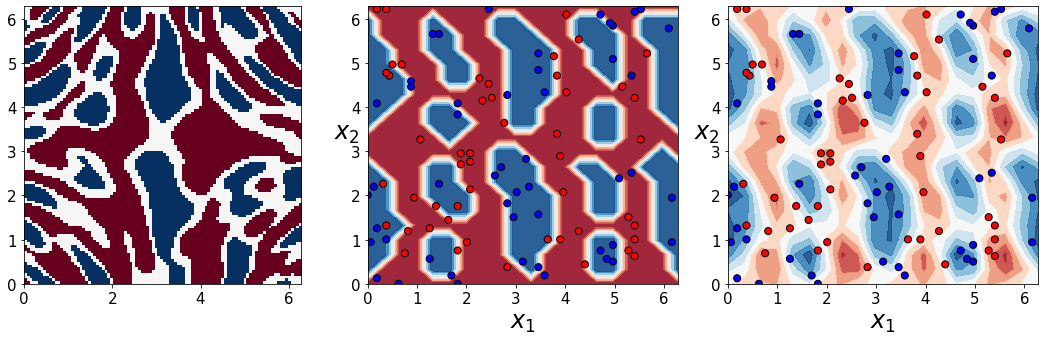

In [9]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=4,
    num_layers=2,
    gates=['h', 'RZ', 'cx',], entanglement='linear',
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QKSVC(feature_map=fm, alpha=2.0, C=1, random_state=seed, backend=backend)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=20)

     ┌───┐ ┌────────────┐                                     ┌───┐ ┌────────────┐                                     
q_0: ┤ H ├─┤ Rz(x[0]*α) ├───■─────────────────────────────────┤ H ├─┤ Rz(x[0]*α) ├───■─────────────────────────────────
     ├───┤ ├────────────┤ ┌─┴─┐                               ├───┤ ├────────────┤ ┌─┴─┐                               
q_1: ┤ H ├─┤ Rz(x[1]*α) ├─┤ X ├──■────────────────────────────┤ H ├─┤ Rz(x[1]*α) ├─┤ X ├──■────────────────────────────
     ├───┤ ├────────────┤ └───┘┌─┴─┐                          ├───┤ ├────────────┤ └───┘┌─┴─┐                          
q_2: ┤ H ├─┤ Rz(x[0]*α) ├──────┤ X ├──■───────────────────────┤ H ├─┤ Rz(x[0]*α) ├──────┤ X ├──■───────────────────────
     ├───┤ ├────────────┤      └───┘┌─┴─┐                     ├───┤ ├────────────┤      └───┘┌─┴─┐                     
q_3: ┤ H ├─┤ Rz(x[1]*α) ├───────────┤ X ├──■──────────────────┤ H ├─┤ Rz(x[1]*α) ├───────────┤ X ├──■──────────────────
     ├───┤ ├────────────┤           └───

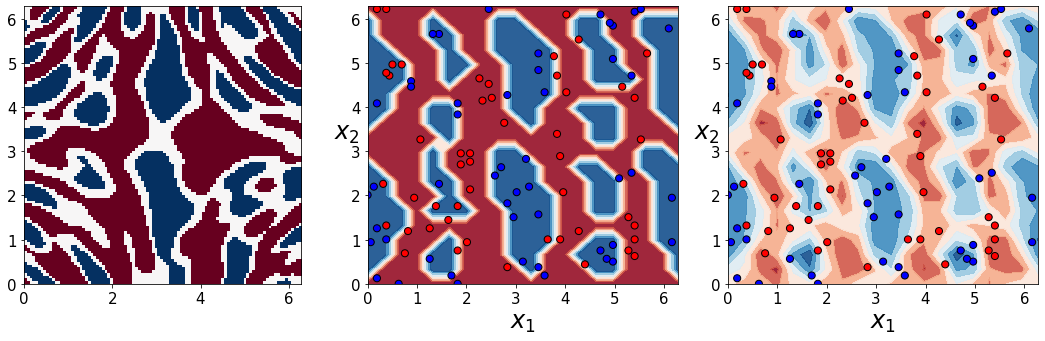

In [10]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=8,
    num_layers=2,
    gates=['h', 'RZ', 'cx',], entanglement='linear',
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QKSVC(feature_map=fm, alpha=2.0, C=1, random_state=seed, backend=backend)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=20)

     ┌───┐ ┌────────────┐                                                                                             »
q_0: ┤ H ├─┤ Rz(x[0]*α) ├──■──────────────────────────────────────────────────────────────────────────────────────────»
     ├───┤ ├────────────┤  │ZZ(x[0]*α)                                                                                »
q_1: ┤ H ├─┤ Rz(x[1]*α) ├──■────────────■─────────────────────────────────────────────────────────────────────────────»
     ├───┤ ├────────────┤               │ZZ(x[1]*α)                                                                   »
q_2: ┤ H ├─┤ Rz(x[0]*α) ├───────────────■────────────■────────────────────────────────────────────────────────────────»
     ├───┤ ├────────────┤                            │ZZ(x[0]*α)                                                      »
q_3: ┤ H ├─┤ Rz(x[1]*α) ├────────────────────────────■────────────■───────────────────────────────────────────────────»
     ├───┤ ├────────────┤               

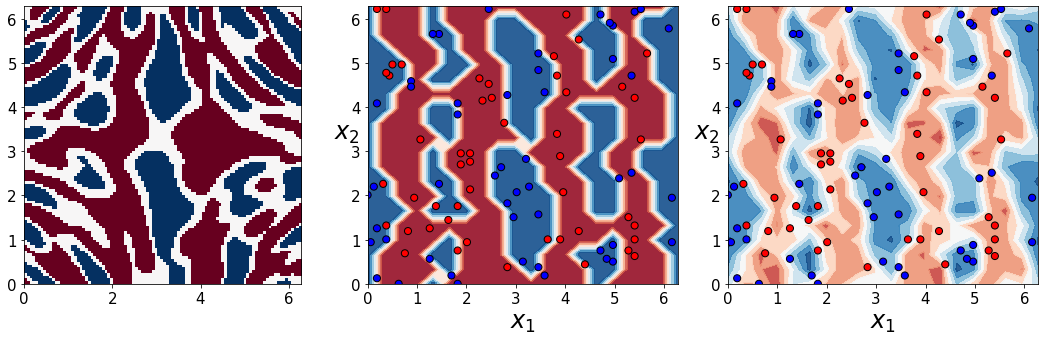

In [11]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=8,
    num_layers=2,
    gates=['H', 'RZ', 'RZZ',], entanglement='linear',
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QKSVC(feature_map=fm, alpha=2.0, C=1, random_state=seed, backend=backend)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=20)

     ┌───┐ ┌────────────┐                                                                                                    ┌───┐ »
q_0: ┤ H ├─┤ Rz(x[0]*α) ├───────■────────────────────────────────────────────────────────────────────────────────────────────┤ H ├─»
     ├───┤ ├────────────┤ ┌─────┴──────┐                                                                                     ├───┤ »
q_1: ┤ H ├─┤ Rz(x[1]*α) ├─┤ Rz(x[0]*α) ├──────■──────────────────────────────────────────────────────────────────────────────┤ H ├─»
     ├───┤ ├────────────┤ └────────────┘┌─────┴──────┐                                                                       ├───┤ »
q_2: ┤ H ├─┤ Rz(x[0]*α) ├───────────────┤ Rz(x[1]*α) ├──────■────────────────────────────────────────────────────────────────┤ H ├─»
     ├───┤ ├────────────┤               └────────────┘┌─────┴──────┐                                                         ├───┤ »
q_3: ┤ H ├─┤ Rz(x[1]*α) ├─────────────────────────────┤ Rz(x[0]*α) ├─

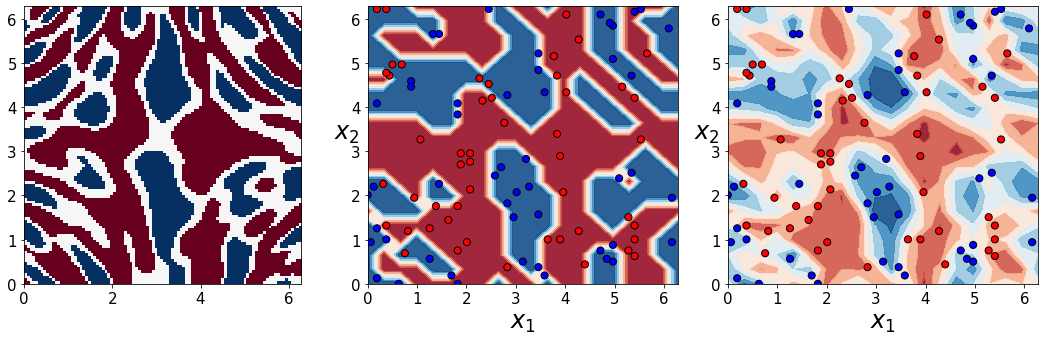

In [12]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=8,
    num_layers=2,
    gates=['h', 'RZ', 'CRZ',], entanglement='linear',
    repeat=True,
)
print(fm.draw(plot_barriers=False, fold=140))

qsvc = QKSVC(feature_map=fm, alpha=2.0, C=1, random_state=seed, backend=backend)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=20)

     ┌───┐ ┌────────────┐ ┌────────────┐                                                                       »
q_0: ┤ H ├─┤ Rz(x[0]*α) ├─┤ Ry(x[0]*α) ├───────■───────────────────────────────────────────────────────────────»
     ├───┤ ├────────────┤ ├────────────┤ ┌─────┴──────┐                                                        »
q_1: ┤ H ├─┤ Rz(x[1]*α) ├─┤ Ry(x[1]*α) ├─┤ Rz(x[0]*α) ├──────■─────────────────────────────────────────────────»
     ├───┤ ├────────────┤ ├────────────┤ └────────────┘┌─────┴──────┐                                          »
q_2: ┤ H ├─┤ Rz(x[0]*α) ├─┤ Ry(x[0]*α) ├───────────────┤ Rz(x[1]*α) ├──────■───────────────────────────────────»
     ├───┤ ├────────────┤ ├────────────┤               └────────────┘┌─────┴──────┐                            »
q_3: ┤ H ├─┤ Rz(x[1]*α) ├─┤ Ry(x[1]*α) ├─────────────────────────────┤ Rz(x[0]*α) ├──────■─────────────────────»
     ├───┤ ├────────────┤ ├────────────┤                             └────────────┘┌─────┴──────

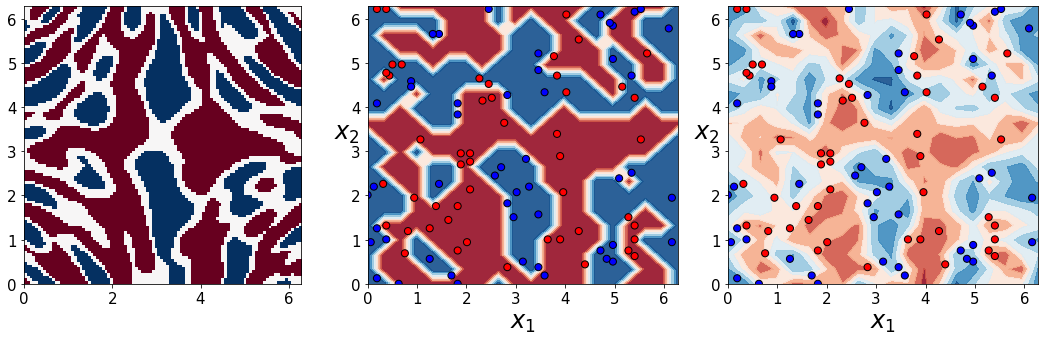

In [13]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=8,
    num_layers=2,
    gates=['h', 'RZ', 'RY', 'CRZ'], entanglement='linear',
    repeat=True,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QKSVC(feature_map=fm, alpha=2.0, C=1, random_state=seed, backend=backend)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=20)

     ┌───┐ ┌────────────┐                                                                                             »
q_0: ┤ H ├─┤ Rz(x[0]*α) ├───■───────────────────────────────────────■─────────────────────────────────────────────────»
     ├───┤ ├────────────┤ ┌─┴─┐                               ┌─────┴──────┐                                          »
q_1: ┤ H ├─┤ Rz(x[1]*α) ├─┤ Y ├──■────────────────────────────┤ Rz(x[0]*α) ├──────■───────────────────────────────────»
     ├───┤ ├────────────┤ └───┘┌─┴─┐                          └────────────┘┌─────┴──────┐                            »
q_2: ┤ H ├─┤ Rz(x[0]*α) ├──────┤ Y ├──■─────────────────────────────────────┤ Rz(x[1]*α) ├──────■─────────────────────»
     ├───┤ ├────────────┤      └───┘┌─┴─┐                                   └────────────┘┌─────┴──────┐              »
q_3: ┤ H ├─┤ Rz(x[1]*α) ├───────────┤ Y ├──■──────────────────────────────────────────────┤ Rz(x[0]*α) ├──────■───────»
     ├───┤ ├────────────┤           └───

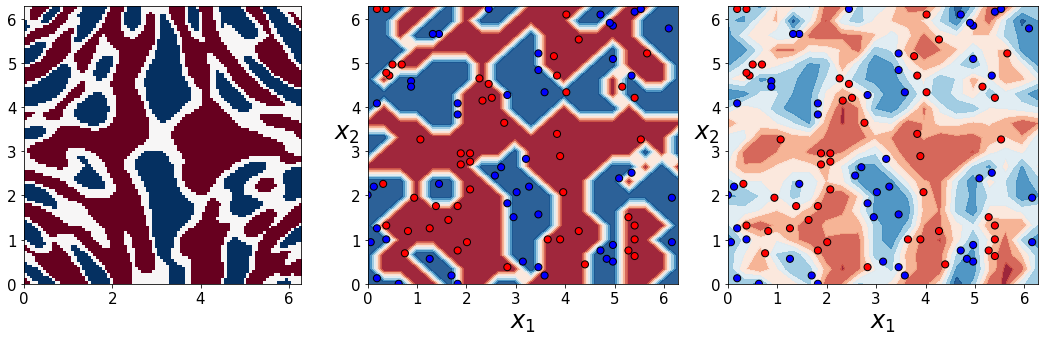

In [14]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=8,
    num_layers=2,
    gates=['H', 'RZ', 'CY', 'CRZ'], entanglement='linear',
    repeat=True,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QKSVC(feature_map=fm, alpha=2.0, C=1, random_state=seed, backend=backend)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=20)

## Hyperparameter search

In [15]:
def model(params):

    qsvc = QKSVC(
        n_qubits=params['n_qubits'],
        n_layers=params['n_layers'],
        feature_map=params['feature_map'], entanglement='linear',
        alpha=params['alpha'], C=params['C'], 
        random_state=seed
    )
    qsvc.fit(X_train, y_train)

    train_scores = get_scores(qsvc, X_train, y_train)
    print_scores(train_scores, title='Train scores:')

    test_scores  = get_scores(qsvc, X_test,  y_test)
    print_scores(test_scores, title='Test scores:')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    plot_predictions(qsvc, ax1, axes, N=20)
    plot_dataset(X[::5,:], y[::5], ax1, axes)
    plot_decisions(qsvc, ax2, axes, N=20)
    plot_dataset(X[::5,:], y[::5], ax2, axes)
    plt.tight_layout()
    plt.show()

In [16]:
np.random.seed(seed=seed)

param_grid = {
    "alpha": [0.5, 1.0, 1.5, 2.0, 2.5],
    "C": [1],
    "n_layers": [1, 2, 3, 4],
    "n_qubits": [8],
    "feature_map": [
                    ['H', 'RZ'], 
                    ['H', 'RZ', 'CZ'], 
                    ['H', 'RZ', 'CX'], 
                    ['H', 'RZ', 'CRZ'], 
                    ['H', 'RZ', 'CRX'], 
                    ['H', 'RZ', 'RY', 'CRZ'], 
                   ],
}

gs = GridSearchCV(
    estimator=QKSVC(entanglement='linear', random_state=seed),
    param_grid=param_grid,
    scoring='matthews_corrcoef',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=seed),
)
gs.fit(X_train, y_train)

print('Best grid search parameters:', gs.best_params_)
print('Best training score:', gs.best_score_)

train_scores = get_scores(gs.best_estimator_, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(gs.best_estimator_, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

Best grid search parameters: {'C': 1, 'alpha': 1.5, 'feature_map': ['H', 'RZ', 'CRZ'], 'n_layers': 4, 'n_qubits': 8}
Best training score: 0.7343891978339808

Train scores:
   Balanced accuracy:  0.99
                  F1:  0.99
             ROC_AUC:  1.00
                 MCC:  0.97

Test scores:
   Balanced accuracy:  0.88
                  F1:  0.88
             ROC_AUC:  0.94
                 MCC:  0.76


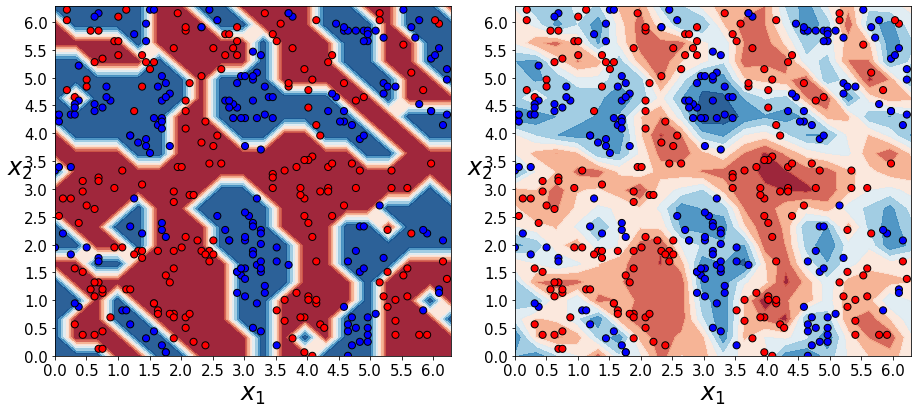

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_predictions(gs.best_estimator_, ax1, axes, N=20)
plot_dataset(X[::5,:], y[::5], ax1, axes)
plot_decisions(gs.best_estimator_, ax2, axes, N=20)
plot_dataset(X[::5], y[::5], ax2, axes)
plt.tight_layout()
plt.show()

In [18]:
v = gs.cv_results_['mean_test_score']
s = gs.cv_results_['std_test_score']

idxs = np.where((v > 0.70) & (s < 0.14))[0]
print(idxs)

for i in idxs:
    print(i, v[i])
    print(gs.cv_results_['params'][i])

[39 61 63 85]
39 0.7098692968806258
{'C': 1, 'alpha': 1.0, 'feature_map': ['H', 'RZ', 'CRZ'], 'n_layers': 4, 'n_qubits': 8}
61 0.7041273398081085
{'C': 1, 'alpha': 1.5, 'feature_map': ['H', 'RZ', 'CRZ'], 'n_layers': 2, 'n_qubits': 8}
63 0.7343891978339808
{'C': 1, 'alpha': 1.5, 'feature_map': ['H', 'RZ', 'CRZ'], 'n_layers': 4, 'n_qubits': 8}
85 0.7141088476111213
{'C': 1, 'alpha': 2.0, 'feature_map': ['H', 'RZ', 'CRZ'], 'n_layers': 2, 'n_qubits': 8}


63
{'C': 1, 'alpha': 2.0, 'feature_map': ['H', 'RZ', 'CRZ'], 'n_layers': 2, 'n_qubits': 8}

Train scores:
   Balanced accuracy:  0.99
                  F1:  0.99
             ROC_AUC:  1.00
                 MCC:  0.97

Test scores:
   Balanced accuracy:  0.87
                  F1:  0.87
             ROC_AUC:  0.93
                 MCC:  0.74


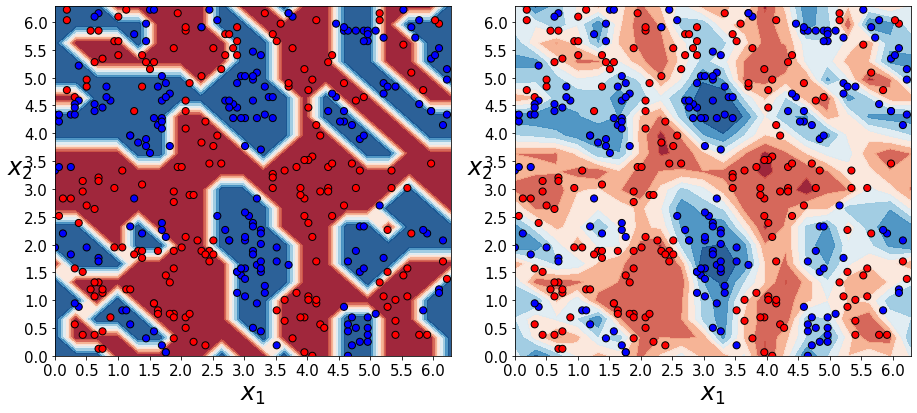

In [19]:
print(gs.best_index_)

i = 85
params = gs.cv_results_['params'][i]
print(params)
model(params)

## Model cross-validation

In [20]:
np.random.seed(seed)

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

train_size = 300
test_size = 50
n_splits = 5

for _seed in np.random.randint(2**16-1, size=5):
    # print('rnd seed', _seed)

    cv = StratifiedShuffleSplit(
        n_splits=n_splits, 
        train_size=train_size, test_size=test_size, 
        random_state=_seed
    )

    i = 0
    for train, test in cv.split(X, y):
        i += 1
        # print(f"Train/Test CV Subset {i}")

        params = {'C': 1, 'alpha': 2.0, 'feature_map': ['H', 'RZ', 'CRZ'], 'n_layers': 2, 'n_qubits': 8} 
        
        qsvc = QKSVC(
            n_qubits=params['n_qubits'],
            n_layers=params['n_layers'],
            feature_map=params['feature_map'], entanglement='linear',
            alpha=params['alpha'], C=params['C'], 
            random_state=_seed
        ) 
        qsvc.fit(X[train,:], y[train])

        train_scores = get_scores(qsvc, X[train,:], y[train])
        test_scores = get_scores(qsvc, X[test,:], y[test])
        scores_tr.append(train_scores)
        scores_tt.append(test_scores)
        if test_scores[scoring] > best_score:
            best_score = test_scores[scoring]
            best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')


==== Cross-Validation Scores ====

Best train score:  0.96

Train set:
   Balanced accuracy:  0.98 +- 0.01
                  F1:  0.98 +- 0.01
             ROC_AUC:  1.00 +- 0.00
                 MCC:  0.96 +- 0.02

Test set:
   Balanced accuracy:  0.88 +- 0.04
                  F1:  0.88 +- 0.04
             ROC_AUC:  0.95 +- 0.03
                 MCC:  0.77 +- 0.09


# Circuit visualization

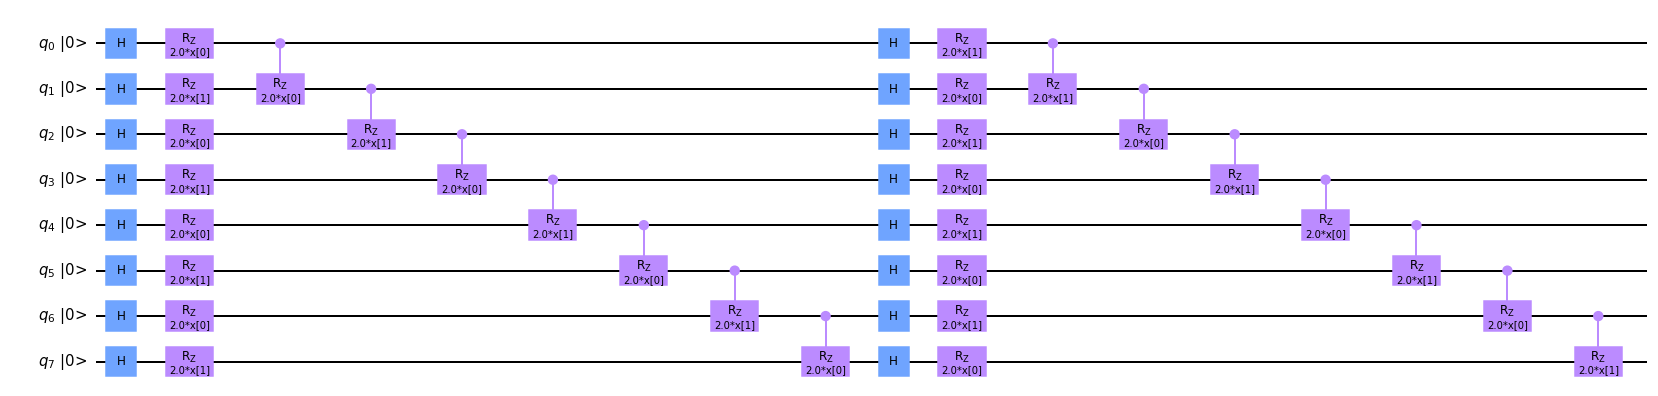

In [21]:
from qksvm.QuantumFeatureMap import QuantumFeatureMap

## Specify Feature Map
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=8,
    num_layers=2,
    gates=['H', 'RZ', 'CRZ',], entanglement='linear',
    alpha=2.0
)

large_font = {
    "fontsize": 12,
    "subfontsize": 10,  
}
fm.draw(plot_barriers=False, fold=180, output='mpl', scale=1, style=large_font, initial_state=True)